In [1]:
from torch.utils.data.dataloader import DataLoader
from torch import optim
from torch import nn 
import torch
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch
from torchvision.datasets import VOCDetection
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt 
import os 
import time 
import random
from PIL import Image,ImageDraw

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE=224  # resnet backbone决定的
S=7
C=20
LAMBDA_COORD=5
LAMBDA_NOOBJ=0.5


# VOC数据集

In [3]:
voc_ds=VOCDetection(root='./data',year='2012',image_set='train',download=True)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


{'annotation': {'folder': 'VOC2012', 'filename': '2008_000008.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '442', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'horse', 'pose': 'Left', 'truncated': '0', 'occluded': '1', 'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'}, 'difficult': '0'}, {'name': 'person', 'pose': 'Unspecified', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'}, 'difficult': '0'}]}}


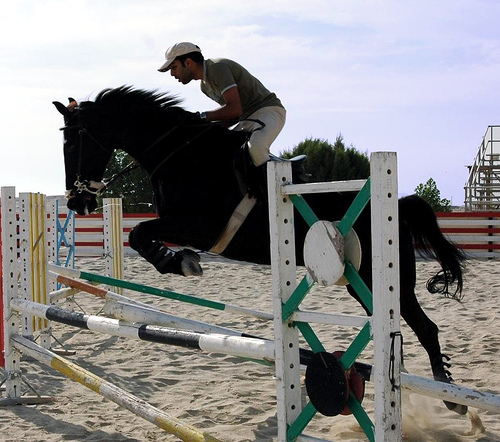

In [4]:
img,label=voc_ds[0]
print(label)
img

In [5]:
img.size

(500, 442)

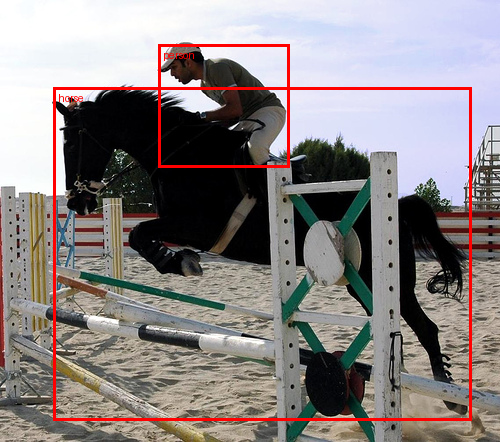

In [6]:
# 画框工具
draw=ImageDraw.Draw(img)

# 遍历每个object
for obj in label['annotation']['object']:
    box=obj['bndbox']
    draw.rectangle([int(box['xmin']),int(box['ymin']),int(box['xmax']),int(box['ymax'])],
                   outline='red',
                   width=3)
    draw.text([int(box['xmin'])+5,int(box['ymin'])+5],obj['name'],fill='red')

img

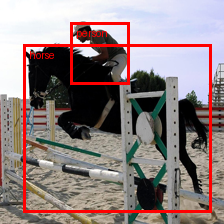

In [7]:
img,label=voc_ds[0]

scaled_img=img.resize((IMG_SIZE,IMG_SIZE)) # 缩放至YoloV1的输入尺寸

# 缩放比
x_scale=IMG_SIZE/img.width
y_scale=IMG_SIZE/img.height

draw=ImageDraw.Draw(scaled_img)
for obj in label['annotation']['object']:
    box=obj['bndbox']
    draw.rectangle([int(box['xmin'])*x_scale,int(box['ymin'])*y_scale,int(box['xmax'])*x_scale,int(box['ymax'])*y_scale],
                   outline='red',
                   width=3)
    draw.text([int(box['xmin'])*x_scale+5,int(box['ymin'])*y_scale+5],obj['name'],fill='red')

scaled_img

# Dataset

In [8]:
class YoloVOCDataset(Dataset):
    def __init__(self,image_set='train'):
        super().__init__()
        self.voc_ds=VOCDetection(root='./data',year='2012',image_set=image_set,download=True)
        
        classdict=set()
        for _,label in self.voc_ds:
            for obj in label['annotation']['object']:
                classdict.add(obj['name'])
        names=sorted(list(classdict))
        self.id2name={i:c for i,c in enumerate(names)}
        self.name2id={c:i for i,c in self.id2name.items()}
    
    def __getitem__(self,index):
        img,label=self.voc_ds[index]
    
        x_scale=IMG_SIZE/img.width
        y_scale=IMG_SIZE/img.height
        grid_size=IMG_SIZE//S
        
        scaled_img=img.resize((IMG_SIZE,IMG_SIZE))
        x=ToTensor()(scaled_img)
        y=torch.zeros(S,S,10+C)
        
        for obj in label['annotation']['object']:
            box=obj['bndbox']
            classid=self.name2id[obj['name']]
            
            # normal coordinates
            xmin,ymin,xmax,ymax=int(box['xmin'])*x_scale,int(box['ymin'])*y_scale,int(box['xmax'])*x_scale,int(box['ymax'])*y_scale
            xcenter,ycenter=(xmin+xmax)/2,(ymin+ymax)/2
            width,height=xmax-xmin,ymax-ymin
            grid_i,grid_j=int(ycenter//grid_size),int(xcenter//grid_size)
            
            # yolo coordinates
            xcenter,ycenter=xcenter%grid_size/grid_size,ycenter%grid_size/grid_size
            width,height=width/IMG_SIZE,height/IMG_SIZE
            
            # targets
            y[grid_i,grid_j,0:5]=y[grid_i,grid_j,5:10]=torch.tensor([xcenter,ycenter,width,height,1])   # x,y,w,h,c
            y[grid_i,grid_j,10:]=torch.zeros(20)
            y[grid_i,grid_j,10+classid]=1
        return x,y
    
    def __len__(self):
        return len(self.voc_ds)

In [9]:
ds=YoloVOCDataset()

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [10]:
x,y=ds[0]
x.shape,y.shape

(torch.Size([3, 224, 224]), torch.Size([7, 7, 30]))

# YoloV1 Model

In [11]:
class YoloV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 用imagenet预训练过的backbone
        resnet=resnet50(ResNet50_Weights.DEFAULT) # (batch,2048,14,14)
        self.backbone=nn.Sequential(
            *list(resnet.children())[:-2],
        )
        for param in self.backbone.parameters():
            param.requires_grad=False
            
        self.head=nn.Sequential(
            nn.Conv2d(in_channels=2048,out_channels=1024,kernel_size=3,padding=1), # (batch,1024,14,14)
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1), # (batch,1024,7,7)
            nn.LeakyReLU(0.1),
            
            nn.Flatten(),
            nn.Linear(in_features=S*S*1024,out_features=4096),
            nn.Dropout(),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=4096,out_features=S*S*(10+C)),
            nn.Sigmoid(),
        )
    
    def forward(self,x): # x:(batch,3,448,448)
        y=self.backbone(x) # (batch,1024,7,7)
        y=self.head(y) # (batch,S*S*(10+C))
        return y.view(-1,S,S,10+C)

In [12]:
model=YoloV1()
x,y=ds[0]
outputs=model(x.unsqueeze(0))
outputs.shape

c:\Users\owen\miniconda3\envs\yolov1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


torch.Size([1, 7, 7, 30])

# Train

In [13]:
def compute_iou(grid_row,grid_col,xywh_a,xywh_b):
    grid_size=IMG_SIZE//S
    
    # yolo coordinates
    xcenter_a,ycenter_a,w_a,h_a=xywh_a
    xcenter_b,ycenter_b,w_b,h_b=xywh_b
    
    # normal coordinates
    xcenter_a,ycenter_a=(grid_col+xcenter_a)*grid_size,(grid_row+ycenter_a)*grid_size
    w_a,h_a=w_a*IMG_SIZE,h_a*IMG_SIZE
    xcenter_b,ycenter_b=(grid_col+xcenter_b)*grid_size,(grid_row+ycenter_b)*grid_size
    w_b,h_b=w_b*IMG_SIZE,h_b*IMG_SIZE
    
    # border
    xmin_a,xmax_a,ymin_a,ymax_a=xcenter_a-w_a/2,xcenter_a+w_a/2,ycenter_a-h_a/2,ycenter_a+h_a/2
    xmin_b,xmax_b,ymin_b,ymax_b=xcenter_b-w_b/2,xcenter_b+w_b/2,ycenter_b-h_b/2,ycenter_b+h_b/2
    
    # IOU
    inter_xmin=max(xmin_a,xmin_b)
    inter_xmax=min(xmax_a,xmax_b)
    inter_ymin=max(ymin_a,ymin_b)
    inter_ymax=min(ymax_a,ymax_b)
    if inter_xmax<inter_xmin or inter_ymax<inter_ymin:
        return 0

    inter_area=(inter_xmax-inter_xmin)*(inter_ymax-inter_ymin) # 交集
    union_area=w_a*h_a+w_b*h_b-inter_area # 并集
    return inter_area/union_area # IOU

In [ ]:
checkpoint=None
try:
    checkpoint=torch.load('checkpoint.pth')
except Exception as e:
    pass

model=YoloV1().to(device)
if checkpoint:
    model.load_state_dict(checkpoint['model'])
    
optimizer=optim.Adam([param for param in model.parameters() if param.requires_grad],lr=3e-5)
if checkpoint:    
    optimizer.load_state_dict(checkpoint['optimizer'])

ds=YoloVOCDataset()
dataloader=DataLoader(ds,batch_size=64,shuffle=True)

writer=SummaryWriter(f'runs/{time.strftime("%Y-%m-%d-%H-%M-%S",time.localtime())}')   # tensorboard

model.train()
losses=[]
for epoch in range(500):
    batch_avg_loss=0
    for batch_x,batch_y in dataloader:
        batch_x,batch_y=batch_x.to(device),batch_y.to(device)
        batch_output=model(batch_x)
        
        loss=torch.tensor(0)
        for i in range(len(batch_x)):
            x=batch_x[i]
            y=batch_y[i]
            output=batch_output[i]
            # foreach grid 
            for row in range(S):    
                for col in range(S):
                    pred_grid=output[row,col] 
                    target_grid=y[row,col]
                    if not target_grid[4]>0: # no object in this grid
                        loss_c_noobj=(pred_grid[4])**2+(pred_grid[9])**2 # no object in grid,so target c is 0
                        loss=loss+LAMBDA_NOOBJ*loss_c_noobj
                        continue 
                    # IOU
                    iou_bbox1=compute_iou(row,col,pred_grid[:4],target_grid[:4])
                    iou_bbox2=compute_iou(row,col,pred_grid[5:9],target_grid[:4])
                    # 取IOU大的预测框的x,y,w,h,c
                    if iou_bbox1>iou_bbox2:
                        xywh=pred_grid[:4]
                        c_obj,c_noobj=pred_grid[4],pred_grid[9]
                        iou_obj,iou_noobj=iou_bbox1,iou_bbox2
                    else:
                        xywh=pred_grid[5:9]
                        c_obj,c_noobj=pred_grid[9],pred_grid[4]
                        iou_obj,iou_noobj=iou_bbox2,iou_bbox1
                    loss_xywh=(xywh[0]-target_grid[0])**2+(xywh[1]-target_grid[1])**2+(torch.sqrt(xywh[2])-torch.sqrt(target_grid[2]))**2+(torch.sqrt(xywh[3])-torch.sqrt(target_grid[3]))**2
                    loss_c_obj=(c_obj-iou_obj)**2
                    loss_c_noobj=c_noobj**2
                    loss_class=((pred_grid[10:]-target_grid[10:])**2).sum()
                    loss=loss+loss_xywh*LAMBDA_COORD+loss_c_obj+loss_c_noobj*LAMBDA_NOOBJ+loss_class
        loss=loss/len(batch_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_avg_loss+=loss.item()
    
    batch_avg_loss=batch_avg_loss/len(dataloader)
    losses.append(batch_avg_loss)
    
    if len(losses)==1 or losses[-1]<losses[-2]: # 保存更优的model
        torch.save({'model':model.state_dict(),
                    'optimizer':optimizer.state_dict()},'.checkpoint.pth')
        os.replace('.checkpoint.pth','checkpoint.pth')
    writer.add_scalar('loss',losses[-1],epoch) # tersorboard
    
    EARLY_STOP_PATIENCE=5   # 早停忍耐度
    if len(losses)>=EARLY_STOP_PATIENCE:
        early_stop=True
        for i in range(1,EARLY_STOP_PATIENCE):
            if losses[-i]<losses[-i-1]:
                early_stop=False
                break
        if early_stop:
            print(f'early stop, final loss={losses[-1]}')
            break

# eval

In [24]:
# 绘制目标框
def draw_objects(draw,img,row,col,output_boxes,objname): # output_boxes是某grid下的1个bbox
    grid_size=IMG_SIZE/S
    
    # normal coodinates
    cx,cy=grid_size*(col+output_boxes[0]),grid_size*(row+output_boxes[1])
    w,h=output_boxes[2]*IMG_SIZE,output_boxes[3]*IMG_SIZE
    xmin,ymin,xmax,ymax=cx-w/2,cy-h/2,cx+w/2,cy+h/2
    
    # 缩放到原图坐标
    x_scale=img.width/IMG_SIZE
    y_scale=img.height/IMG_SIZE
    cx,cy=cx*x_scale,cy*y_scale
    xmin,ymin,xmax,ymax=xmin*x_scale,ymin*y_scale,xmax*x_scale,ymax*y_scale
    
    draw.circle((cx,cy),fill='red',radius=5)
    draw.rectangle((xmin,ymin,xmax,ymax),outline='red')
    draw.text((xmin+5,ymin+5),objname,fill='red')

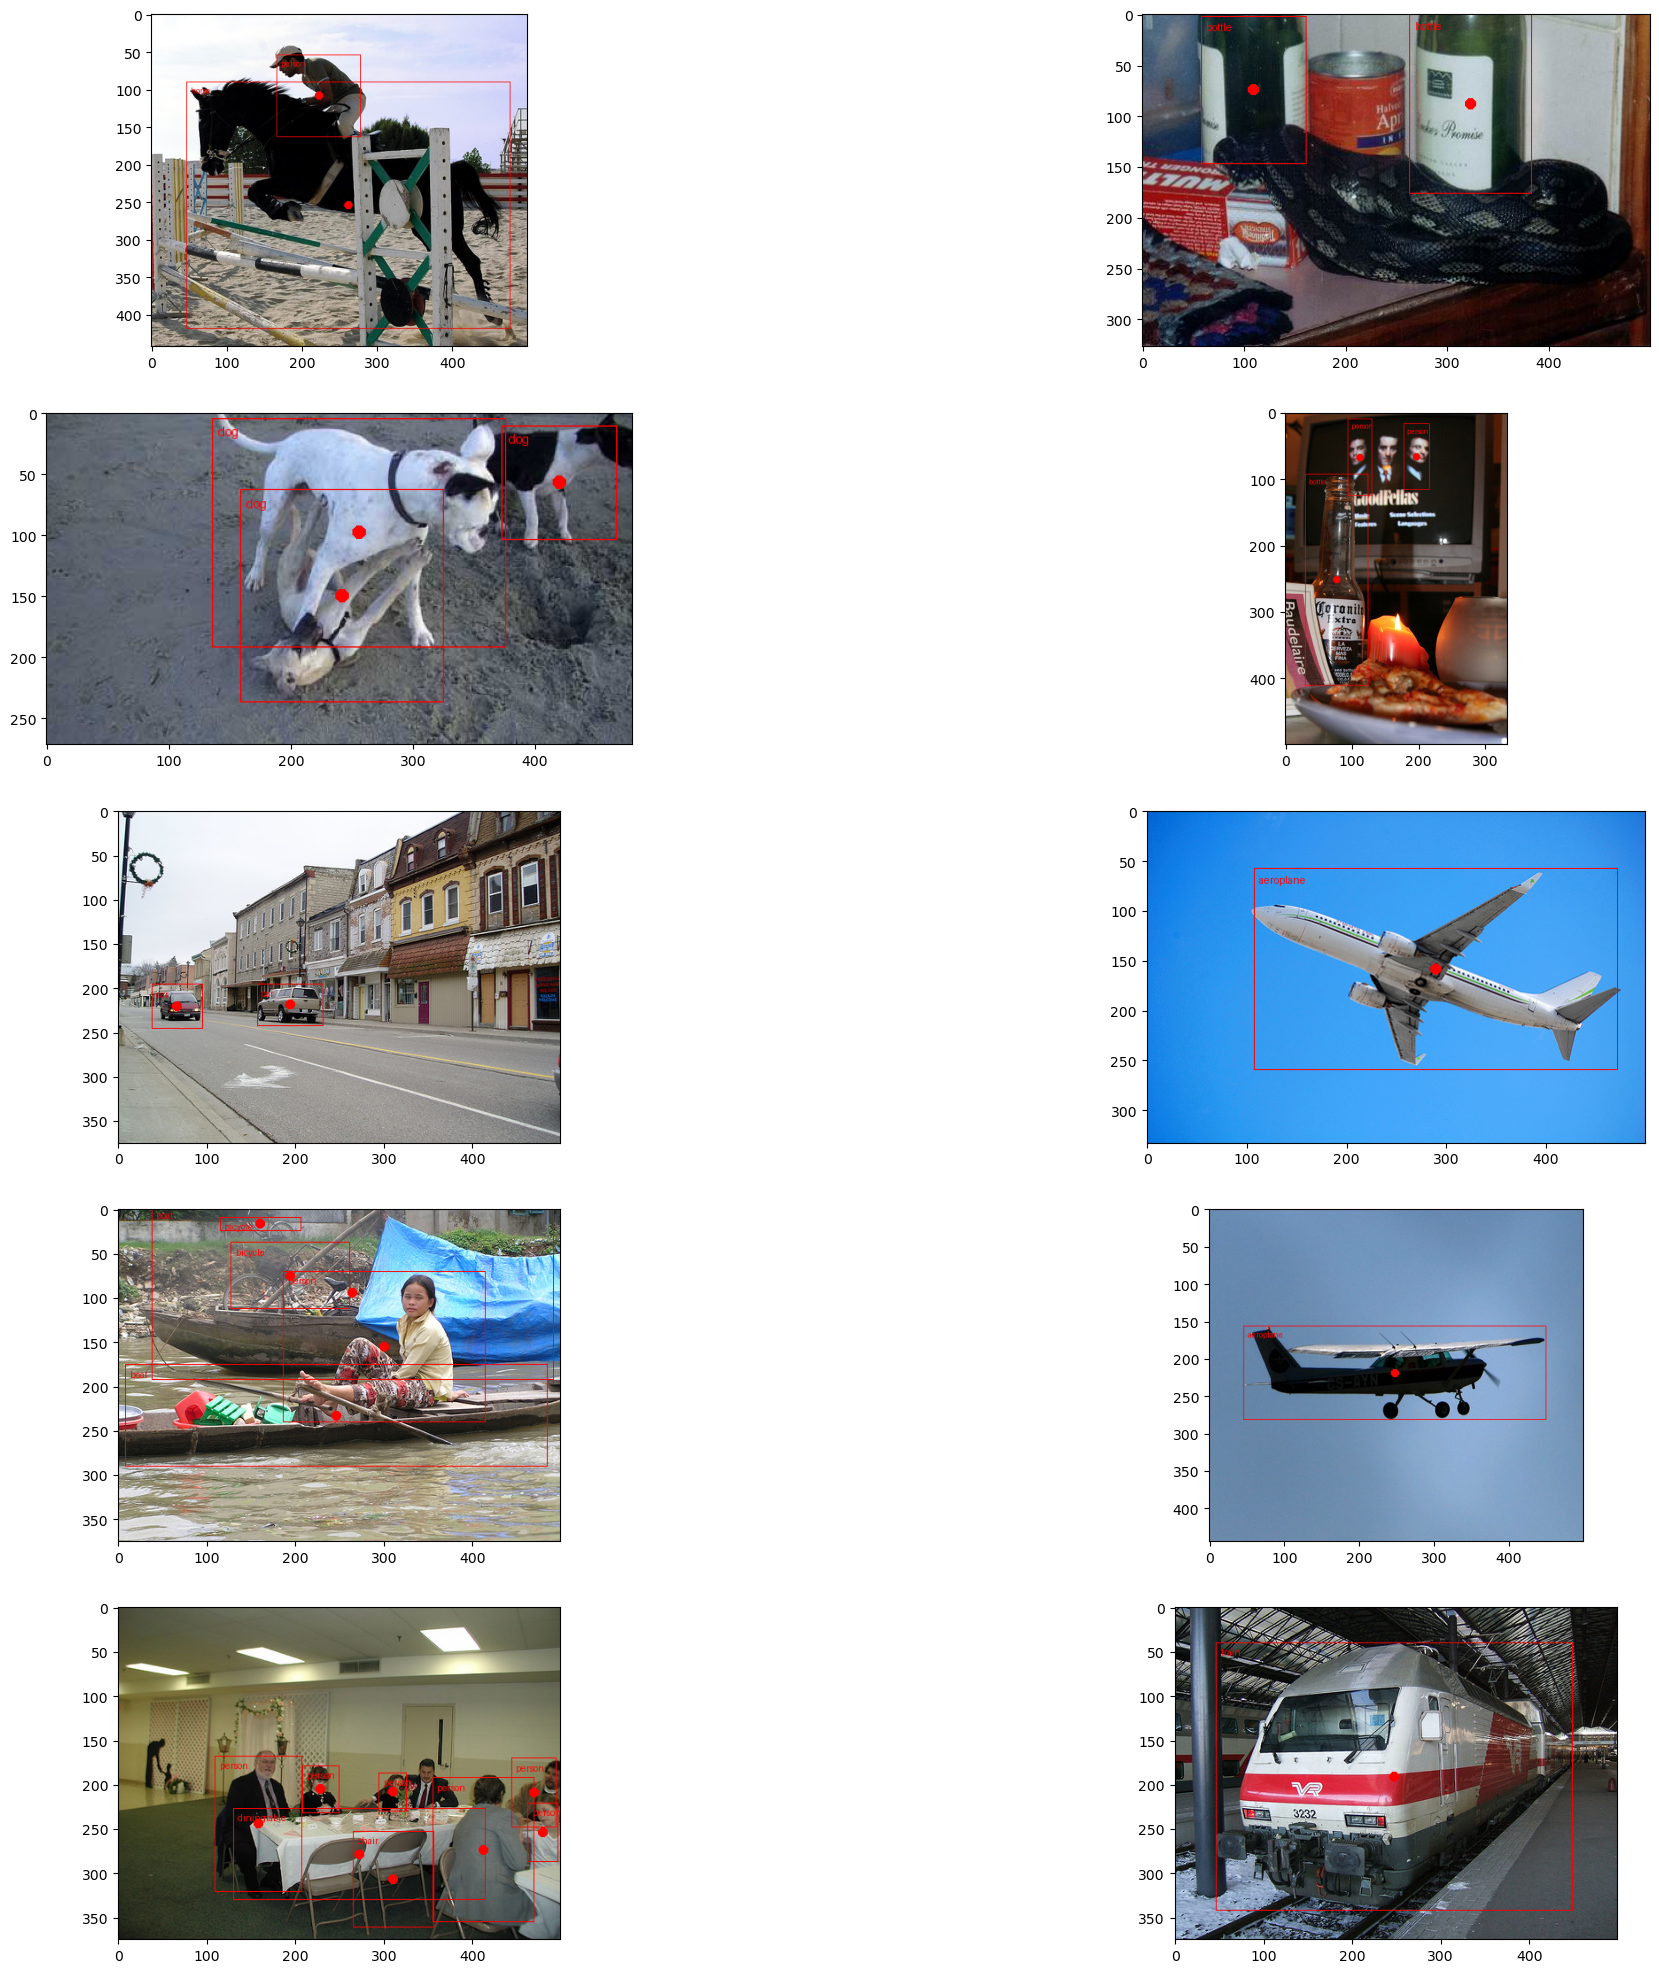

In [25]:
checkpoint=torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model'])
model.eval()

plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,2,i+1)
    x,y=ds[i] # (3,224,224)
    img,_=ds.voc_ds[i]  # 原图

    draw=ImageDraw.Draw(img)

    C_THREADHOLD=0.5

    output=model(x.unsqueeze(0).to(device))[0]
    for row in range(S):
        for col in range(S):
            objname=ds.id2name[output[row,col,10:].argmax().item()]
            if output[row,col,4]>C_THREADHOLD:
                draw_objects(draw,img,row,col,output[row,col,:5],objname)
            if output[row,col,9]>C_THREADHOLD:
                draw_objects(draw,img,row,col,output[row,col,5:10],objname)
    plt.imshow(img)